# **Potato Disease Classification using CNN**

## **Introduction**

Potato (Solanum tuberosum) is one of the most important staple crops worldwide, providing a significant source of nutrition. However, the yield and quality of potato crops are frequently threatened by various diseases, among which early blight and late blight are particularly devastating. These diseases not only reduce crop yield but also increase the cost of production due to the need for disease management and control measures. Early and accurate identification of these diseases is crucial to mitigate their impact and ensure a healthy harvest.

Traditionally, disease detection in potato plants has relied on visual inspection by experienced agronomists or farmers, which can be time-consuming and prone to human error. With advancements in computer vision and machine learning, automated systems for plant disease detection have become increasingly feasible. These systems can process large amounts of image data and classify plant conditions with high accuracy, offering a promising solution for early disease detection in potato crops.

This research project aims to develop an image classification model to accurately distinguish between healthy potato plants, those affected by early blight, and those affected by late blight. By leveraging the power of Convolutional Neural Networks (CNNs), this study seeks to contribute to the broader effort of enhancing agricultural productivity through technology.

## **Problem Statement**

The manual identification of potato plant diseases, such as early blight and late blight, is labor-intensive and subject to human error, leading to delayed or inaccurate diagnosis. These delays can result in significant crop loss and reduced agricultural productivity. There is a critical need for an automated, accurate, and efficient system that can classify potato plant conditions based on leaf images to enable timely intervention and reduce the impact of these diseases.

## **Objectives**

The primary objectives of this research are:

- To develop an image classification model using Convolutional Neural Networks (CNNs) that can accurately classify potato plant images into three categories: healthy, early blight, and late blight.

- To collect and preprocess a dataset of potato plant leaf images, ensuring that the dataset is balanced and representative of real-world conditions.

- To evaluate the performance of the developed model using appropriate metrics and optimize it for higher accuracy and generalization.

- To explore the potential applications of the model in real-world agricultural settings, particularly in improving disease management and crop monitoring.


## **Metrics of Success**

Target F1-Score:

Reasonable F1-Score Target: 0.85 or higher

Explanation: An F1-Score of 0.85 indicates that the model has a good balance between Precision and Recall, effectively identifying most diseased plants while keeping false positives in check. Achieving an F1-Score of 0.85 or higher suggests that the model is reliable for practical use in detecting potato plant diseases.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers
from IPython.display import HTML



In [26]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

len(dataset) is 68, meaning your dataset has been divided into 68 batches of 32 images each.

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())


(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


Image Batch Shape: 

The shape (32, 256, 256, 3) indicates that the batch contains 32 images, each resized to 256x256 pixels with 3 color channels (RGB). This is expected since you specified IMAGE_SIZE = 256 and BATCH_SIZE = 32.


Labels Batch: 

The array of labels [1, 1, 1, 0, 0, 0, ...] represents the ground truth classes for the 32 images in the batch. The numbers correspond to the index of the class names in the class_names list. The array reflects the shuffled order of the images, ensuring that each batch has a mix of different classes for more effective training.

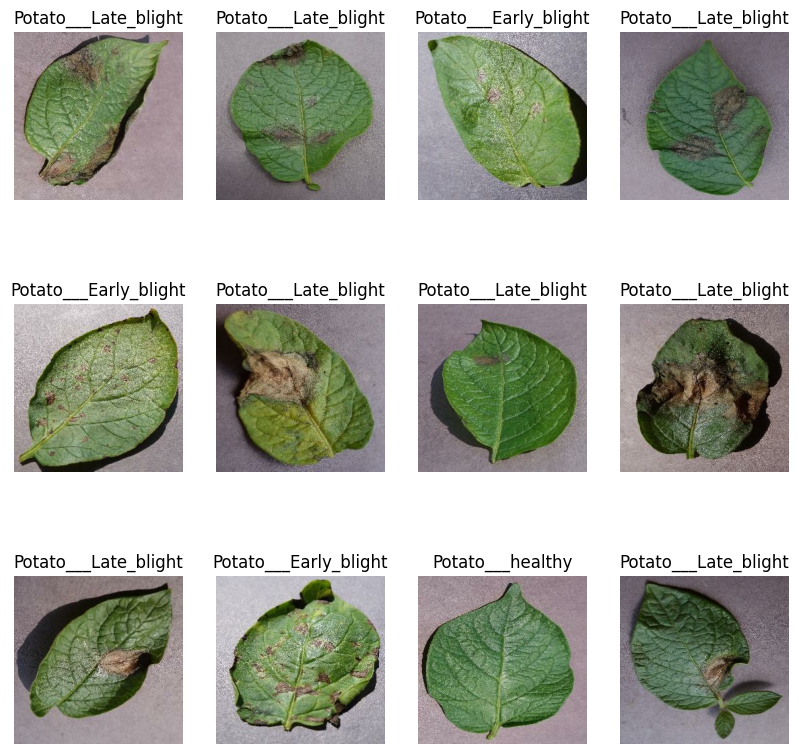

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

Splitting dataset:

80% - Training
20% - 10% on validation and 10% on testing

- Training: Dataset to be used while training

- Validation: Dataset to be tested against while training

- Test: Dataset to be tested against after we trained a model

 Setting the Train Size

In [9]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

 Creating the Train Size

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

Creating the Testing Dataset

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

Setting the Validation Size

In [12]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

Creating the Validation Dataset

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

Updating the Testing Dataset

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

**Performance Optimization**

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Building Model**

In [22]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1./255),
])

In [23]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    layers.Input(shape=input_shape),  # Define the input shape with the Input layer
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# No need to call model.build() explicitly


In [30]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

**Compiling the Model**

adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.4771 - loss: 0.9304 - val_accuracy: 0.6719 - val_loss: 0.6812
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.7296 - loss: 0.5974 - val_accuracy: 0.7760 - val_loss: 0.4380
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.8476 - loss: 0.3942 - val_accuracy: 0.7969 - val_loss: 0.4763
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 154s 3s/step - accuracy: 0.8698 - loss: 0.3181 - val_accuracy: 0.8646 - val_loss: 0.4021
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.9247 - loss: 0.1856 - val_accuracy: 0.8958 - val_loss: 0.3178
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.9350 - loss: 0.1809 - val_accuracy: 0.9427 - val_loss: 0.1856
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.9519 - loss: 0.1258 - val_accuracy: 0.9010 - val_loss: 0.2630
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.9346 - loss: 0.1620 - val_accuracy: 0.9792 - v

In [32]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 500ms/step - accuracy: 0.9885 - loss: 0.0539


The model performed very well on the test dataset, achieving an accuracy of 98.85%, which indicates that it correctly classified most of the test images. The low loss value (0.0539) further supports the model's strong performance

In [33]:
scores

[0.07089532911777496, 0.98046875]

Loss (0.0709): A low loss indicates that the model's predictions are close to the actual values.
Accuracy (0.9805 or 98.05%): A high accuracy indicates that the model is performing very well in correctly classifying the test dataset.

In [34]:
history

In [35]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [36]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [37]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8606606721878052,
 0.5323222279548645,
 0.37093472480773926,
 0.22849391400814056,
 0.16973064839839935]

The decreasing loss suggests your model is learning well in the initial stages.

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

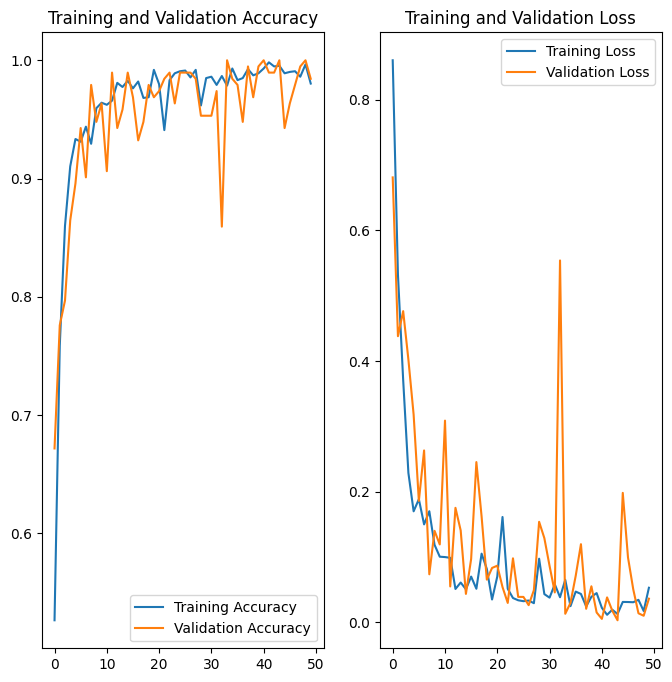

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
predicted label: Potato___Late_blight


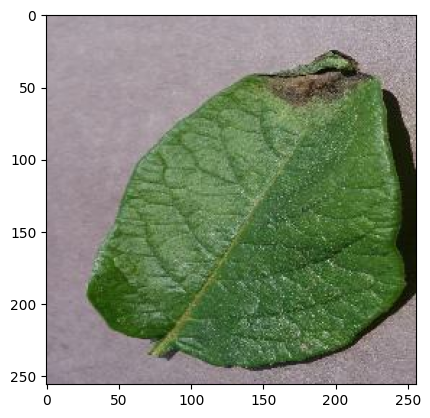

In [40]:

for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


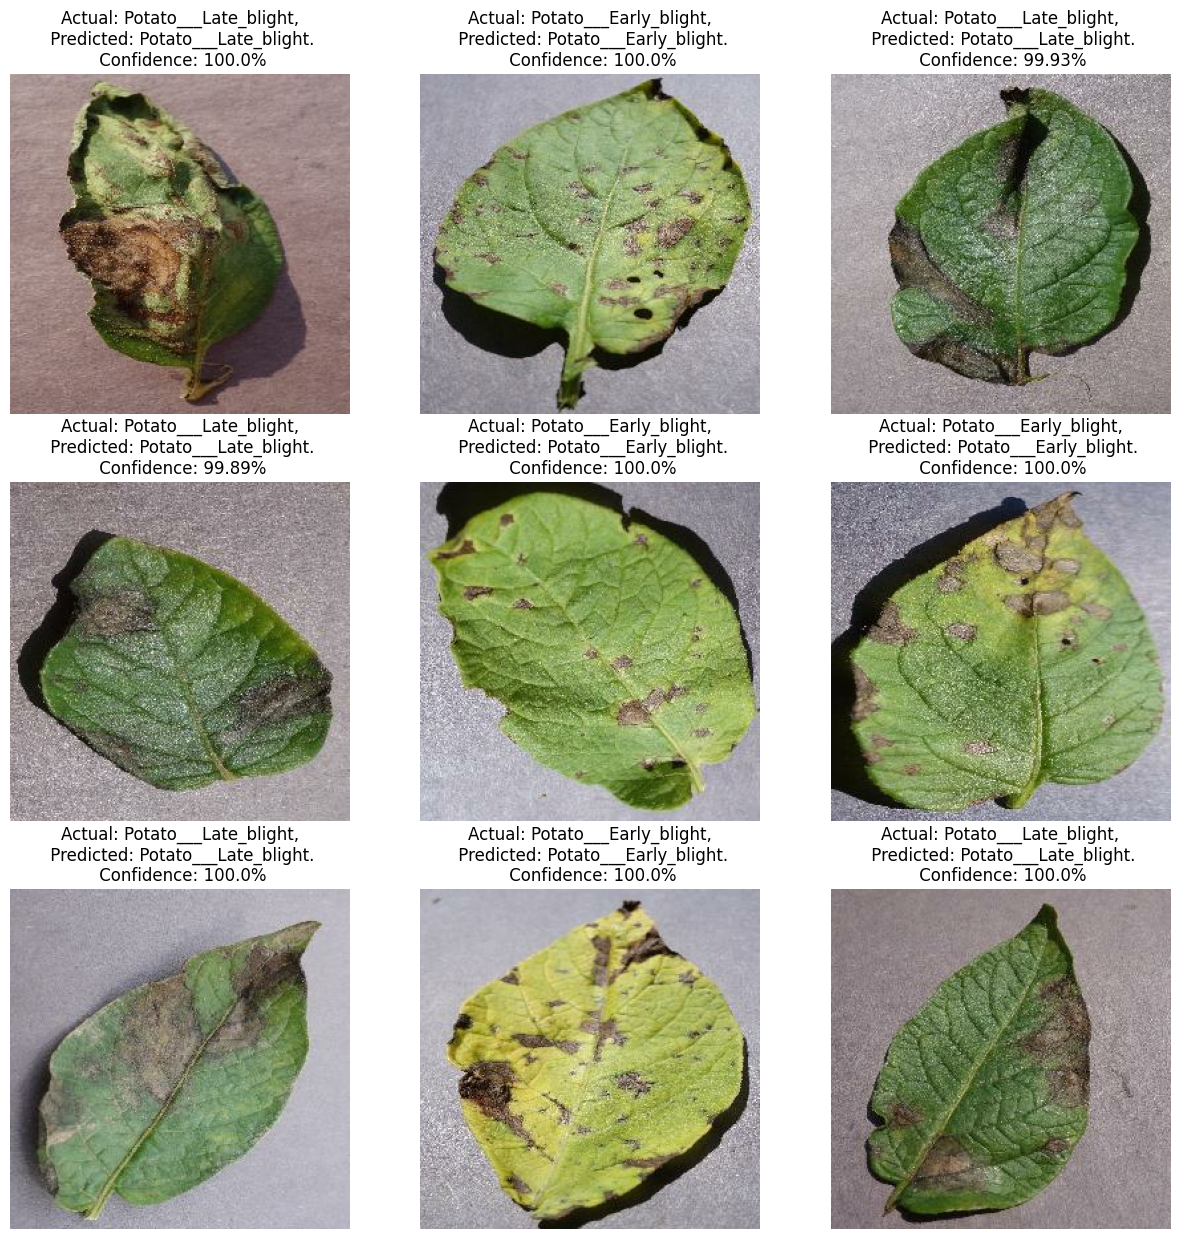

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")